In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from patsy import dmatrices, dmatrix

In [2]:
df = pd.read_csv('Classeur1.csv',sep=';')

df.replace('\..*$','', regex=True,inplace='true')# remove the exact hour of transaction (we are concerned by daily transactions)
df.head()

,client,paysclient,timestamp,canal,montant,commercant
0,1001741,FRA,2011-01-04-21,1,25,2019460
1,1000791,FRA,2011-01-04-21,1,15,2019461
2,1000516,FRA,2011-01-04-21,1,24,2000798
3,1000071,FRA,2011-01-04-21,1,12,2000798
4,1000686,FRA,2011-01-04-21,1,144,2000798


In [3]:
df.count() / df.shape[0]

client        1.000000
paysclient    1.000000
timestamp     1.000000
canal         0.993128
montant       1.000000
commercant    1.000000
dtype: float64

In [4]:
df.replace(np.nan,2.0,inplace='true')   # remove nan values in canal
print len(np.unique(df.commercant.values))

65076


##### Quelques information sur le jeu des données:
Ce jeu de données concerne 3983 clients. Il enregistré sur une période de 6 mois commençant de 2010/12/31  jusqu'à 2011/06/30. On a également deux canaux de dépenses (0,1). Quant aux commerçants, on a 65076.


##I) Analyse descriptive

### I.1) Analyse des dépenses
#### I.1.1) Analyse globale des dépenses

In [5]:
f = lambda x: float(x.replace(' ', ''))
df['montant'] = df.montant.apply(f)  # convert montant from string to float
df['montant'].describe()

count    78584.000000
mean        45.796333
std         83.062752
min          0.000000
25%         15.000000
50%         28.000000
75%         51.000000
max       6933.000000
Name: montant, dtype: float64

(78584,)
45.7963325868


[300, 400, 0, 200]

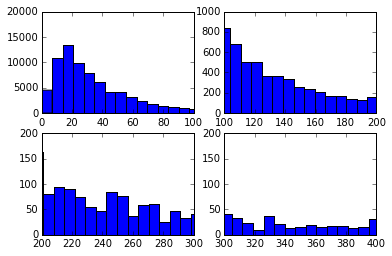

In [6]:
x = df.montant.values
print x.shape
print np.mean(x)
plt.subplot(2, 2, 1)
plt.hist(x,bins=1000)
plt.axis([0,100,0,20000])
#plt.show()

plt.subplot(2, 2, 2)
plt.hist(x,bins=1000)
plt.axis([100,200,0,1000])

plt.subplot(2, 2, 3)
plt.hist(x,bins=1000)
plt.axis([200,300,0,200])

plt.subplot(2, 2, 4)
plt.hist(x,bins=1000)
plt.axis([300,400,0,200])


#plt.show()

A partir de notre jeu de données, on constate:

- Les transcations bancaires les plus fréquentes (5000 jusqu'à 15000 transactions) sont dans la plage de 10 à 50 euros. 
- La fréquece des dépenses pour un seuil supérieur à 50 euros sont de plus en plus faibles et atteignent une fréquence de 900 transcations pour 100 euros. 
- Pour un montant supérieur à 200 euros, la fréquence est inférieur à 100.
- Pour un montant supérieur à 300 euros, la fréquence des dépenses est inférieur à 50.

#### I.1.2) Analyse par client

In [7]:
sum_montant = df.groupby('client')[['montant']].sum()
count_montant = df.groupby('client')[['montant']].count()
client_montant = sum_montant / count_montant     # dépense moyenne par client

print client_montant.shape
client_montant.head()



(3983, 1)


,montant
client,
1000001,12.000000
1000002,86.000000
1000003,29.750000
1000004,54.857143
1000005,174.333333


In [8]:
client_montant.describe()

,montant
count,3983.000000
mean,49.745707
std,63.242092
min,1.000000
25%,23.566964
50%,36.461538
75%,56.480769
max,1381.500000


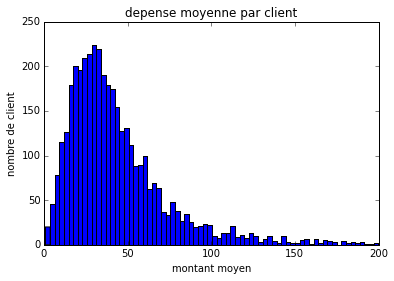

In [9]:
x = client_montant.montant.values
plt.hist(x,bins=500)
plt.axis([0,200,0,250])
plt.title('depense moyenne par client')
plt.xlabel('montant moyen')
plt.ylabel('nombre de client')
plt.show()

Dans ce jeu de données, on a 3983 clients. L'histogramme montre que 75% de la population dépense en moyenne (par transaction) un montant inférieur à 56 euros. 

####I.1.3) Evolution des dépenses en fonction du temps

In [10]:
time_series = df
print type(time_series)
time_series.index = pd.to_datetime(time_series.timestamp)
time_series.head()

<class 'pandas.core.frame.DataFrame'>


,client,paysclient,timestamp,canal,montant,commercant
timestamp,,,,,,
2011-01-04 21:00:00,1001741,FRA,2011-01-04-21,1,25,2019460
2011-01-04 21:00:00,1000791,FRA,2011-01-04-21,1,15,2019461
2011-01-04 21:00:00,1000516,FRA,2011-01-04-21,1,24,2000798
2011-01-04 21:00:00,1000071,FRA,2011-01-04-21,1,12,2000798
2011-01-04 21:00:00,1000686,FRA,2011-01-04-21,1,144,2000798


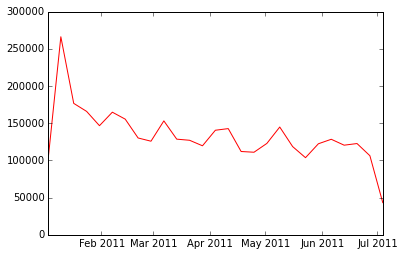

In [11]:
time_series_aggregated = time_series.resample('W-Mon', how=sum)
plt.plot_date(time_series_aggregated.index,time_series_aggregated.montant,fmt="r-",label='depenses')

On remarque un pic de dépenses en début d'année puis elles se stabilisent en cours d'année.

####I.1.4) Répartition des dépenses en fonction du canal d'achat

([<matplotlib.patches.Wedge at 0x7f0752170e50>,
  <matplotlib.text.Text at 0x7f075219b090>])

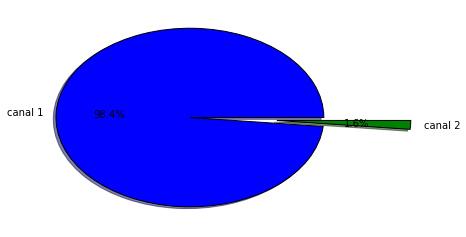

In [12]:
canal_1 = df[df['canal']==1]
canal_2 = df[df['canal']==2]
name = ['canal 1','canal 2']
data_plot = [len(canal_1),len(canal_2)]
explode=(0.15,0.5)
plt.pie(data_plot, explode=explode, labels=name, autopct='%1.1f%%', startangle=0, shadow=True)

99,1 % des achats se font via canal 1 alors que 0.9% se font à travers le canal 2.

####I.1.5) Répartition des dépenses en fonction du commerçant

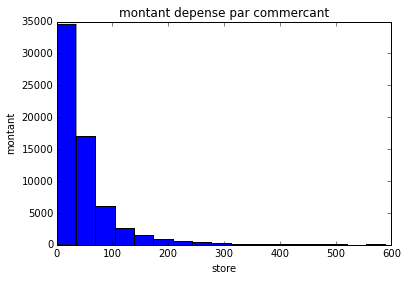

In [13]:
aggregated_commercant = df.groupby('commercant')[['montant']].sum()

#plt.bar(aggregated_commercant.index.values,aggregated_commercant.montant.values)
plt.hist(aggregated_commercant.montant.values,bins=200)
plt.axis([0,600,0,35000])
plt.xlabel('store')
plt.ylabel('montant')
plt.title('montant depense par commercant')
plt.show()

##II) Apprentissage non supervisé

###II.2) Aggregation par client

In [14]:
f = {'montant':['sum'], 'commercant':[lambda x:x.value_counts().index[0]],'canal':[lambda x:x.value_counts().index[0]]}
client_vector = df.groupby('client').agg(f)
client_vector.head()

,canal,commercant,montant
,<lambda>,<lambda>,sum
client,,,
1000001,1,2000087,24
1000002,1,2000084,86
1000003,1,2000176,119
1000004,1,2000159,384
1000005,1,2000141,523


Question: cette transformation est-t-elle la meilleure pour représenter nos observations?

In [15]:
# scale the dataframe
X = client_vector.as_matrix()
print X.shape

(3983, 3)


In [16]:
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)

print X_mean
print X_var

X = preprocessing.scale(X)
X_train = X[:X.shape[0]//2,:]
X_test = X[X.shape[0]//2:,:]

[  1.00351494e+00   2.11552290e+06   9.03554858e+02]
[  3.50258370e-03   1.03434397e+10   1.71935476e+06]


(3983, 2)


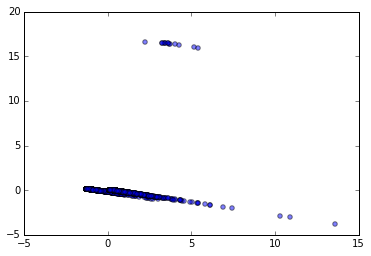

In [17]:
# PCA to data repartition 
pca = PCA(n_components=2)   # generate the two principal axes
axes = pca.fit(X)
princ_comp = np.dot(X,axes.components_.T)
print princ_comp.shape
plt.scatter(princ_comp[:,0], princ_comp[:,1], alpha=0.5)

In [18]:
estimator = KMeans(n_clusters=3, init='k-means++')
estimator.fit(X_train)
res = estimator.predict(X_test)

Comment déterminer le nombre de cluster optimal ?

###II.3) Interpretation des clusters

In [19]:
tmp = estimator.fit(X_train)
centroids = tmp.cluster_centers_

In [20]:
centroids = centroids * (X_var**0.5) + X_mean
print centroids

[[  1.00000000e+00   2.01445006e+06   3.82734785e+02]
 [  1.00000000e+00   2.01703991e+06   2.65446231e+03]
 [  2.00000000e+00   2.02625900e+06   5.21000000e+02]]


On peut intérpréter un cluster à partir de ces centroids:
- Les clients associés au centroids 1 sont principalement des clients qui consomment sur le canal 1 et achétenet souvent du commerçant 2014275. Le montant totale dépensé par ses clients est au alentour de 269 euros sur 6 mois, soit 44.83 euros par mois.
- Les clients associés au centroids 1 sont principalement des clients qui consomment sur le canal 1 et achétenet souvent du commerçant 2017848. Le montant totale dépensé par ses clients est au alentour de 4075 euros sur 6 mois, soit 679.1 euros par mois.
- Les clients associés au centroids 1 sont principalement des clients qui consomment sur le canal 1 et achétenet souvent du commerçant 2016004. Le montant totale dépensé par ses clients est au alentour de 4422 euros sur 6 mois, soit 737 euros par mois.

Req: Il faut garder en tête que nos clusters ne sont pas purs (on a juste analysé les centroids qui sont les plus représentatifs de nos observations)

###II.4) Sans aggrégation par client

In [21]:
# scale the dataframe
features = ['canal','commercant','montant']
X = df[features].as_matrix()

print X_mean
print X_var

X = preprocessing.scale(X)
X_train = X[:X.shape[0]//2,:]
X_test = X[X.shape[0]//2:,:]

estimator = KMeans(n_clusters=3, init='k-means++')
estimator.fit(X_train)
res = estimator.predict(X_test)


[  1.00351494e+00   2.11552290e+06   9.03554858e+02]
[  3.50258370e-03   1.03434397e+10   1.71935476e+06]


/home/khalil/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:153: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [22]:
dic = []
def func(x):
    client_id = df[df['client']==x][features]
    client_matrix = client_id.as_matrix()
    prediction = estimator.predict(client_matrix)
    cluster = stats.mode(prediction)[0][0]
    dic.append((x,cluster))
    
map(func,np.unique(df.client.values))
dic =  dict(dic)

"Dic" contient le cluster dans lequel chaque client il appartient.

##III) Apprentissage supervisé

### III.1) Labellisation

In [23]:
for idx in dic:
     df.loc[df['client']==idx,'label'] = dic[idx]    # adding labels to the data 
df.head()

,client,paysclient,timestamp,canal,montant,commercant,label
timestamp,,,,,,,
2011-01-04 21:00:00,1001741,FRA,2011-01-04-21,1,25,2019460,1
2011-01-04 21:00:00,1000791,FRA,2011-01-04-21,1,15,2019461,1
2011-01-04 21:00:00,1000516,FRA,2011-01-04-21,1,24,2000798,1
2011-01-04 21:00:00,1000071,FRA,2011-01-04-21,1,12,2000798,1
2011-01-04 21:00:00,1000686,FRA,2011-01-04-21,1,144,2000798,1


### III.2) Learning and Prediction phase

In [24]:

features = ['client','montant','commercant','label']
df_selected = df[features]

df_selected['commercant'] = df_selected.commercant.astype(str)

formula = 'label ~  client + montant + commercant'

y,x = dmatrices(formula, data = df_selected,  return_type='dataframe')

n_train = df_selected.shape[0]
X_train = x[:n_train//2].as_matrix()
y_train = y[:n_train//2].as_matrix()[:,0]    # select the firt column of y

X_test = x[n_train//2:].as_matrix()

/home/khalil/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MemoryError: 

La catégorization des commerçants entraine des erreurs mémoire (on a beaucoup de commerçant). Ce sera mieux de les rassembler dans des clusters puis lancer l'algorithme d'apprentissage.